In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch

import osmnx as ox
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
import geopandas
from geopandas.tools import sjoin
from pyproj import Proj, transform
from geopy.distance import distance
from shapely.geometry import LineString, Point, LinearRing

/usr/local/lib/python2.7/dist-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)
/usr/local/lib/python2.7/dist-packages/pysal/contrib/viz/mapping.py:32: UserWarning: Bokeh not installed. Functionality related to it will not work
  warn('Bokeh not installed. Functionality '


In [3]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [4]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
(0.8443906332745678, 0.4051139537590416)


In [5]:
roads = gpd.read_file('../Data/GreaterLondon/edges/edges.shp')

In [6]:
roads['geometry'] = roads['geometry'].buffer(20)

In [7]:
roads.head()

access area bridge est_width       from      highway junction key lanes  \
0                               370068561  residential            0         
1                                95944707  residential            0         
2                                95944671  residential            0         
3                                  277489  residential            0         
4                                  277490  residential            0         

   length maxspeed              name oneway     osmid ref service         to  \
0  17.609   20 mph      Epstein Road  False  10780443               95944704   
1  68.247   20 mph  Galsworthy Close  False  10780432               95944704   
2  41.109   20 mph      Epstein Road  False  10780443               95944704   
3  29.564   30 mph    Woodside Grove  False   3398626              193724417   
4  80.433   30 mph    Woodside Grove  False   3398626              193724417   

  tunnel width                                           geometry  
0               POLYGON ((715928.833 5710288.050, 715927.194 5...  
1               POLYGON ((715922.267 5710262.711, 715920.552 5...  
2               POLYGON ((715904.245 5710319.576, 715905.814 5...  
3               POLYGON ((695292.876 5722769.750, 695290.926 5...  
4               POLYGON ((695288.785 5722809.220, 695291.733 5...

In [8]:
roads.crs

{'init': u'epsg:32630'}

In [9]:
roads_WGS84 = roads.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [10]:
roads_WGS84.head()

access area bridge est_width       from      highway junction key lanes  \
0                               370068561  residential            0         
1                                95944707  residential            0         
2                                95944671  residential            0         
3                                  277489  residential            0         
4                                  277490  residential            0         

   length maxspeed              name oneway     osmid ref service         to  \
0  17.609   20 mph      Epstein Road  False  10780443               95944704   
1  68.247   20 mph  Galsworthy Close  False  10780432               95944704   
2  41.109   20 mph      Epstein Road  False  10780443               95944704   
3  29.564   30 mph    Woodside Grove  False   3398626              193724417   
4  80.433   30 mph    Woodside Grove  False   3398626              193724417   

  tunnel width                                           geometry  
0               POLYGON ((0.11130 51.50241, 0.11128 51.50241, ...  
1               POLYGON ((0.11119 51.50219, 0.11117 51.50220, ...  
2               POLYGON ((0.11097 51.50271, 0.11099 51.50272, ...  
3               POLYGON ((-0.17870 51.62202, -0.17873 51.62202...  
4               POLYGON ((-0.17874 51.62237, -0.17869 51.62237...

In [10]:
# shp_roads = fiona.open('../Data/Geo_Data/geo/london_wards.shp')

# shp_roads.crs

In [11]:
len(roads)

161911

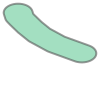

In [12]:
roads_WGS84.iloc[20]['geometry']

In [13]:
# samples = gpd.read_file('../Data/GreaterLondon/edges/samples.shp')

In [14]:
mapillary_points = pd.read_csv('../Data/Mappilary_points_merged.csv')

In [15]:
tree_data = pd.read_csv('../Data/Geo_Data/london_street_trees_gla_20180214.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
mapillary_points.head()

Unnamed: 0                  Imgkey       Sky  Building      Pole  \
0           0  wE0jAFaY7S7kBlobMy3nPA  0.288501  0.104387  0.031655   
1           1  k_syhXZRKg-blx5cCvFdBg  0.168970  0.000347  0.004676   
2           2  iVXnlg3PQMPspbTFqRD9eA  0.021730  0.146528  0.012488   
3           3  amVTOx7uE0GuMkeN2ECC3w  0.249045  0.156707  0.001586   
4           4  46aeChblLDzqF3p4UjXb7g  0.061244  0.003218  0.000405   

   Road_Marking      Road  Pavement      Tree  Sign_Symbol  ...   Vehicle  \
0      0.006545  0.334103  0.012228  0.094468     0.006325  ...  0.102205   
1      0.015434  0.240914  0.104091  0.455197     0.000156  ...  0.000006   
2      0.034340  0.262760  0.138669  0.303953     0.000434  ...  0.032488   
3      0.000017  0.146730  0.073339  0.352066     0.000012  ...  0.017598   
4      0.000527  0.147847  0.052610  0.707002     0.000764  ...  0.004624   

   Pedestrian      Bike  Unnamed: 0.1               captureTime isPano  \
0    0.006343  0.000006        155358  2017-01-09T11:16:58.080Z  False   
1    0.000087  0.000000        331930  2019-08-20T20:07:23.000Z  False   
2    0.041644  0.002297         92492  2019-06-09T17:11:34.567Z  False   
3    0.000839  0.001007        205329  2015-04-15T11:11:25.227Z  False   
4    0.000382  0.000000        121677  2016-08-29T16:15:48.000Z  False   

         lat      long  long_lat_string                       geometry  
0  51.458700 -0.195153  -0.1952_51.4587  POINT (-0.1951528 51.4586997)  
1  51.395208  0.007908   0.0079_51.3952   POINT (0.0079077 51.3952076)  
2  51.532153  0.055075   0.0551_51.5322   POINT (0.0550746 51.5321528)  
3  51.522573 -0.036350  -0.0363_51.5226  POINT (-0.0363496 51.5225733)  
4  51.622794 -0.136517  -0.1365_51.6228  POINT (-0.1365167 51.6227944)  

[5 rows x 21 columns]

In [17]:
m = Basemap(
    projection='merc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

In [18]:
treeLocations = []

for index , row in tree_data.iterrows():
#     point = Point(m(row['longitude'], row['latitude']))
    point = Point(row['longitude'], row['latitude'])
#     point = Point(transform(inProj,outProj,row['longitude'], row['latitude']))
    treeLocations.append(point)

print treeLocations[1]

tree_points = pd.Series(treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))

POINT (0.1391226851333678 51.58566970615966)


In [71]:
mapLocations = {}
for index , row in mapillary_points.iterrows():
#     point = Point(m(row['long'], row['lat']))
    point = Point(row['long'], row['lat'])
    mapLocations[row['Imgkey']] = point

# map_points = pd.Series(mapLocations)
# map_data_points = MultiPoint(list(map_points.values))

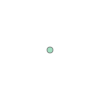

In [72]:
mapLocations[mapLocations.keys()[1]]

In [20]:
from dask import dataframe
import multiprocessing
from tqdm import tqdm
tqdm.pandas()

In [74]:
def distKm(Points_tuple):
    return distance(Points_tuple[0], Points_tuple[1]).km


def pointsCount(geometry , points):
    within = []
    for p in points: 
        if p.within(geometry):
            within.append(p)
    return within

def approxPointsCount(geometry, points):
    bufferdist = 0.01
    poly = geometry.buffer(bufferdist)
    centroid = poly.centroid.xy
    print centroid
    within = []
    for p in points: 
        if distance(p,centroid) <= bufferdist:
            within.append(p)
    return pd.Series(within)

def filterMappilary(geometry , pointsKeys):
    within = []
    for k in pointsKeys: 
        p = pointsKeys[k]
        if p.within(geometry):
            within.append(k)
    return within

In [22]:
roads_dd = dataframe.from_pandas(roads_WGS84,npartitions=2*multiprocessing.cpu_count())

In [23]:
within  = roads_WGS84[1000:1020]['geometry'].progress_apply(pointsCount, args = [map_points])
within

100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


1000                                                   []
1001                                                   []
1002                                                   []
1003                                                   []
1004    [POINT (-0.261083 51.551804), POINT (-0.260854...
1005    [POINT (-0.261083 51.551804), POINT (-0.260854...
1006    [POINT (-0.2602881 51.55186810000001), POINT (...
1007    [POINT (-0.2653876 51.5475383), POINT (-0.2630...
1008                                                   []
1009                                                   []
1010                                                   []
1011                                                   []
1012                                                   []
1013                                                   []
1014                                                   []
1015                                                   []
1016                                                   []
1017    [POINT

In [24]:
# within_trees  = roads_dd.map_partitions(lambda df:df['geometry'].progress_apply(pointsCount, args = [tree_points]), meta=pd.Series('list')).compute(scheduler='processes')

 69%|██████▉   | 2800/4048 [5:00:41<2:10:06,  6.26s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▍  | 2989/4048 [5:21:54<1:53:33,  6.43s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 79%|███████▊  | 3171/4039 [5:41:13<1:32:07,  6.37s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Noteb

In [25]:
# %store within_Trees

UsageError: Unknown variable 'within_Trees'


In [26]:
# %store within_trees
%store -r within_trees

Stored 'within_trees' (Series)


In [31]:
roads_WGS84['Trees'] = 0

In [42]:
roads_WGS84.iloc[4048]

access                                                        
area                                                          
bridge                                                        
est_width                                                     
from                                                 232788632
highway                                            residential
junction                                                      
key                                                          0
lanes                                                         
length                                                  88.429
maxspeed                                                      
name                                               Cedar Drive
oneway                                                   False
osmid                                                  5216933
ref                                                           
service                                                

In [44]:
for index, row in roads_WGS84.iterrows():
    roads_WGS84.at[index,'trees'] = len(within_trees[index])

In [46]:
# %store roads_WGS84

Stored 'roads_WGS84' (GeoDataFrame)


In [251]:
roads_filtered = roads_WGS84[roads_WGS84['trees']>10]

In [252]:
len(roads_filtered)

22544

In [73]:
roads_filtered_dd = dataframe.from_pandas(roads_filtered,npartitions=2*multiprocessing.cpu_count())

In [66]:
np.median(roads_WGS84['trees'])

1.0

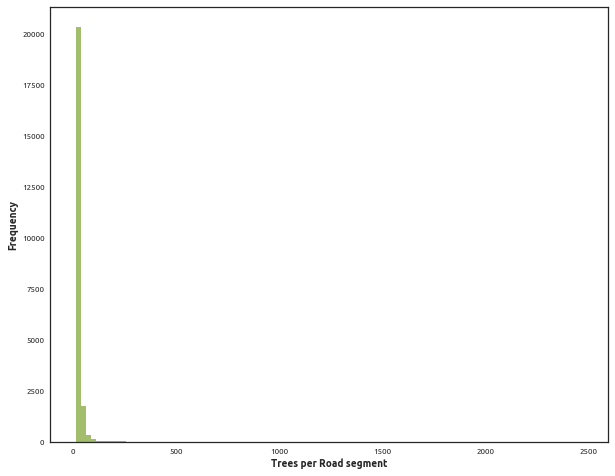

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Trees per Road segment')
plt.ylabel('Frequency')
# plt.axvline(thresh_low, color='r')
# plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(roads_filtered['trees'], 100, facecolor='g', alpha=0.75)

In [76]:
# within_mp  = roads_filtered_dd.map_partitions(lambda df:df['geometry'].progress_apply(filterMappilary, args = [mapLocations]), meta=pd.Series('list')).compute(scheduler='processes')

100%|██████████| 564/564 [30:01<00:00,  3.19s/it]


In [77]:
# %store within_mp
store -r within_mp

Stored 'within_mp' (Series)


In [78]:
# within_mp

11                                                       []
30                                                       []
37                                                       []
39                                                       []
49                                                       []
51                                                       []
52                                                       []
64                                                       []
66                                                       []
67                                                       []
68                                                       []
70                                                       []
76                                                       []
95                                                       []
111                                                      []
121                                                      []
122                                     

In [81]:
# roads_filtered['Mappilary'] = 0.0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [196]:
for k in within_mp.index:
    if len(within_mp[k]) > 0:
        map_trees = mapillary_points[mapillary_points['Imgkey'].isin(within_mp[k])]
        roads_WGS84.at[k,'Mappilary_trees'] = np.sum(map_trees['Tree'])+0.000001
        roads_WGS84.at[k,'Mappilary_samples'] = len(map_trees)

In [197]:
len(roads_WGS84)

161911

In [198]:
final_roads = roads_WGS84[roads_WGS84[['Mappilary_trees', 'Mappilary_samples']].notnull().all(1)]

In [247]:
final_roads = final_roads[final_roads['trees'] > 10 ] 

In [246]:
len(final_roads)

5017

In [201]:
# final_roads_meters = final_roads.to_crs("+proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
# final_roads_meters.iloc[1000].geometry

In [202]:
final_roads['Tree_density'] = 0.00001
final_roads['Tree_pixel_density'] = 0.00001

In [203]:
minValue = min(final_roads['Mappilary_trees'])
print minValue

1e-06


In [204]:
for index , row in final_roads.iterrows():
    tree_density =  np.log(float(row['trees'])/float(row['length'])) 
    pixel_density = np.log(float(row['Mappilary_trees'])/float(row['length']))
#     print tree_density , pixel_density
    final_roads.at[index,'Tree_density'] = tree_density
    final_roads.at[index,'Tree_pixel_density'] = pixel_density

In [205]:
final_roads.head()

access area bridge est_width        from      highway junction key lanes  \
129                               2681439063        trunk            0     2   
130                               2681439063  residential            0         
131                                 25916142        trunk            0     2   
194                               5731971885      primary            0         
195                                219439006  residential            0         

      length  ... tunnel width  \
129  331.843  ...                
130  138.311  ...                
131  285.297  ...                
194  166.167  ...                
195  155.102  ...                

                                              geometry Trees trees Mappilary  \
129  POLYGON ((0.05748 51.43739, 0.05749 51.43739, ...     0  38.0         0   
130  POLYGON ((0.05390 51.43815, 0.05385 51.43866, ...     0  11.0         0   
131  POLYGON ((0.05096 51.43916, 0.05097 51.43915, ...     0  14.0         0   
194  POLYGON ((-0.33916 51.60985, -0.33916 51.60983...     0  33.0         0   
195  POLYGON ((-0.33861 51.60877, -0.33863 51.60876...     0  13.0         0   

    Mappilary_trees Mappilary_samples Tree_density Tree_pixel_density  
129       16.901992              65.0    -2.167076          -2.977230  
130        7.133323              32.0    -2.531609          -2.964728  
131       25.500800             200.0    -3.014473          -2.414821  
194        4.364092              15.0    -1.616486          -3.639583  
195        0.865643               3.0    -2.479134          -5.188365  

[5 rows x 27 columns]

In [215]:
# %store final_roads

Stored 'final_roads' (GeoDataFrame)


(0.2617591793363447, 2.1769196247424192e-79)


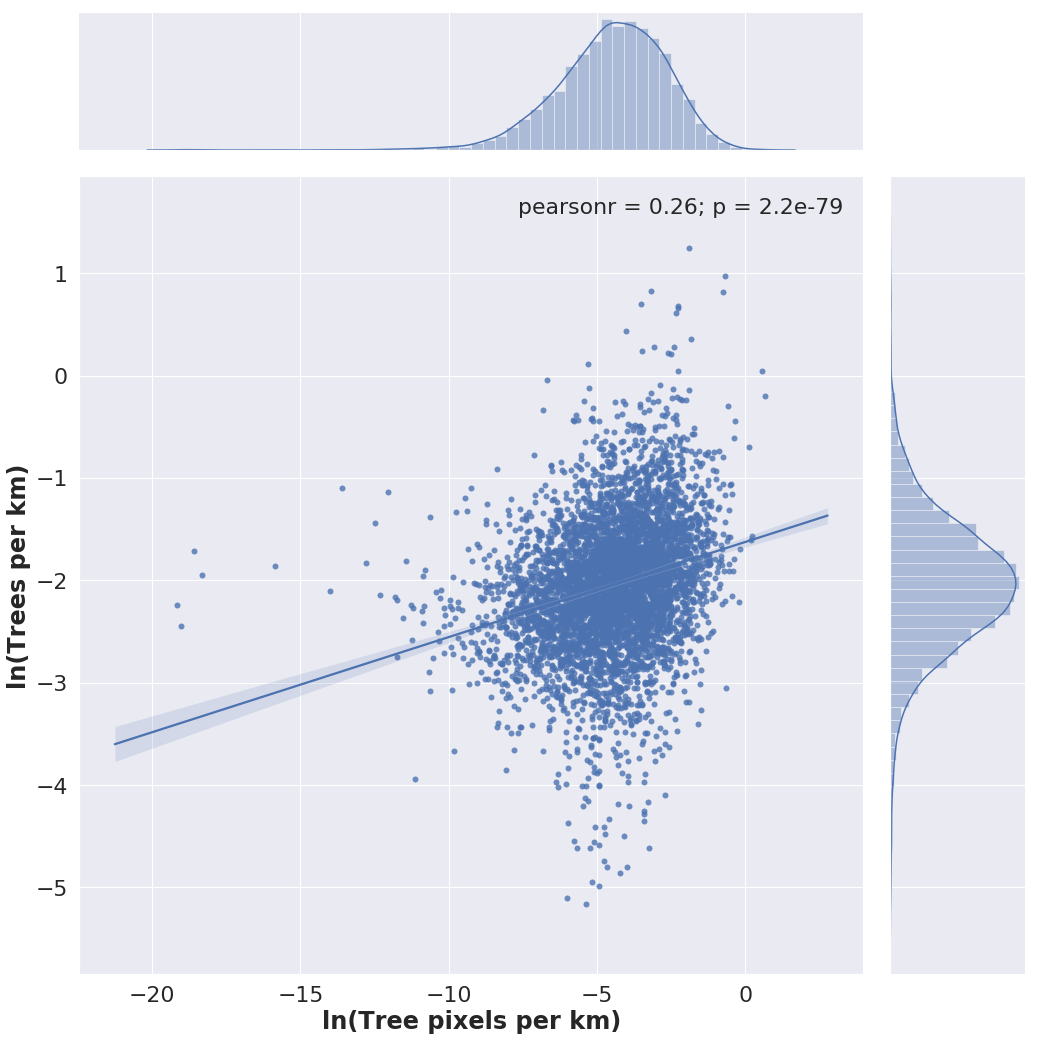

In [210]:
from scipy.stats import pearsonr
corr = pearsonr(final_roads['Tree_density'],final_roads['Tree_pixel_density'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x=final_roads['Tree_pixel_density'], y=final_roads['Tree_density'], kind='regression',height=15);
plt.xlabel('ln(Tree pixels per km)')
plt.ylabel('ln(Trees per km)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

In [217]:
final_roads[:1000]

access area bridge est_width        from       highway junction key  \
129                                 2681439063         trunk            0   
130                                 2681439063   residential            0   
131                                   25916142         trunk            0   
194                                 5731971885       primary            0   
195                                  219439006   residential            0   
196                                 5853683511       primary            0   
226                                   18130223   residential            0   
298                                  130239730      tertiary            0   
405                                 2143544028   residential            0   
409                                     196854   residential            0   
422                                 5620945587   residential            0   
440                                  101319760   residential            0   
441                                  269527796       primary            0   
442                                  269527798       primary            0   
501                                 3714580971     secondary            0   
502                                 3714580985     secondary            0   
503                                 3714580967      tertiary            0   
506                                     200102   residential            0   
529                                     227700       primary            0   
631                                  272725364   residential            0   
808                                 1619521350     secondary            0   
825                  yes             283311395       primary            0   
843                                  663885157  unclassified            0   
907                                   12779182       primary            0   
1091                                 135791608  unclassified            0   
1097                                 247989245         trunk            0   
1146      no                          32555018  unclassified            0   
1162                                  21496906   residential            0   
1181                                    215568       primary            0   
1182                                  21496930       primary            0   
...      ...  ...    ...       ...         ...           ...      ...  ..   
30797                                   295389       primary            0   
30799                                   295398       primary            0   
30805                               1768342652   residential            0   
30860                                   819754   residential            0   
30976                               3112824519      tertiary            0   
31047                                   195838   residential            0   
31059                                   198825   residential            0   
31060                               1695262387   residential            0   
31063                               1695262387     secondary            0   
31094                                 32929857   residential            0   
31160                                   197591       primary            0   
31180                yes                295835         trunk            0   
31182                yes            1452626238         trunk            0   
31184                yes            1668991637         trunk            0   
31193                                 26787925   residential            0   
31194                                   109655   residential            0   
31207                                137660336      tertiary            0   
31309                                104321806         trunk            0   
31369                                   296097    trunk_link            0   
31370                yes            1463979482    trunk_link            0   
31

In [231]:
final_roads['samples_per_km'] = 0.0
for i , row in final_roads.iterrows():
    density = float(row['Mappilary_samples'])/float(row['length'])
    final_roads.at[i,'samples_per_km'] = density

In [237]:
final_roads['decile'] = pd.qcut(final_roads['Mappilary_samples'], q=10, precision=0)

In [238]:
corrs = []
bins = []
for name, group in final_roads.groupby('decile'):
    bins.append(name)
    corr = pearsonr(group['Tree_density'],group['Tree_pixel_density'])
    corrs.append(corr)

In [239]:
corrs

[(0.4017659800210301, 1.4086806736070062e-30),
 (0.4728595741029271, 2.4196688939483685e-19),
 (0.5815405315184462, 8.267280926838813e-51),
 (0.5295763505442949, 1.0149761017806923e-39),
 (0.6039659719952858, 1.0384604842769007e-42),
 (0.5329281301714619, 4.963028909864381e-38),
 (0.5707427312446156, 8.02208446810055e-40),
 (0.5992808814823108, 1.5948532898694426e-51),
 (0.6531311821315665, 4.868862746907008e-61),
 (0.6211372720524763, 2.3148049647760823e-54)]

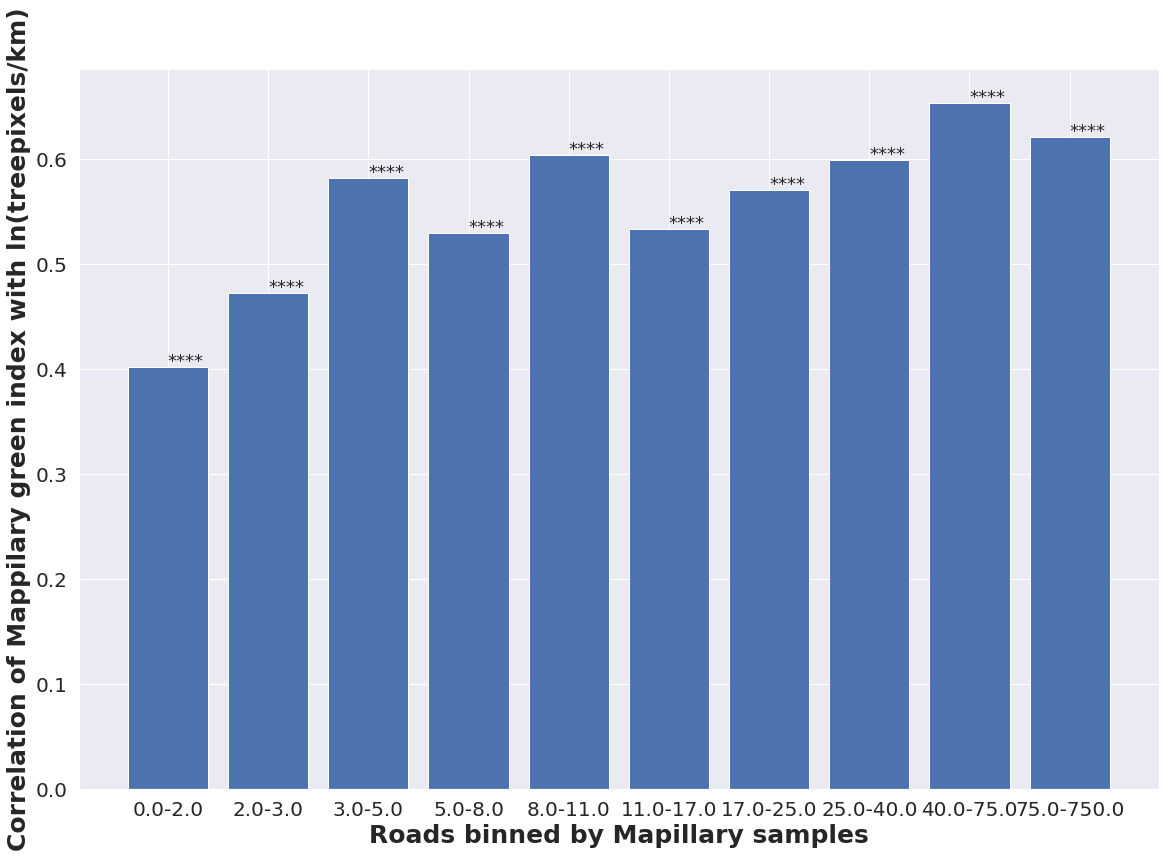

In [241]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Roads binned by Mapillary samples",fontsize = 25)
plt.ylabel("Correlation of Mappilary green index with ln(treepixels/km)",fontsize = 25)
xlabels = [str(b.left)+'-'+str(b.right) for b in bins]
c = [corr[0] for corr in corrs]
ax.bar(xlabels,c)

p = []
for corr in corrs: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [242]:
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['name'], xy=(r["Tree_density"], r["Tree_pixel_density"]), 
            xytext=(2,2) , textcoords ="offset points", fontsize = 10)

(0.4017659800210301, 1.4086806736070062e-30)
(0.4728595741029271, 2.4196688939483685e-19)
(0.5815405315184462, 8.267280926838813e-51)
(0.5295763505442949, 1.0149761017806923e-39)
(0.6039659719952858, 1.0384604842769007e-42)
(0.5329281301714619, 4.963028909864381e-38)
(0.5707427312446156, 8.02208446810055e-40)
(0.5992808814823108, 1.5948532898694426e-51)
(0.6531311821315665, 4.868862746907008e-61)
(0.6211372720524763, 2.3148049647760823e-54)


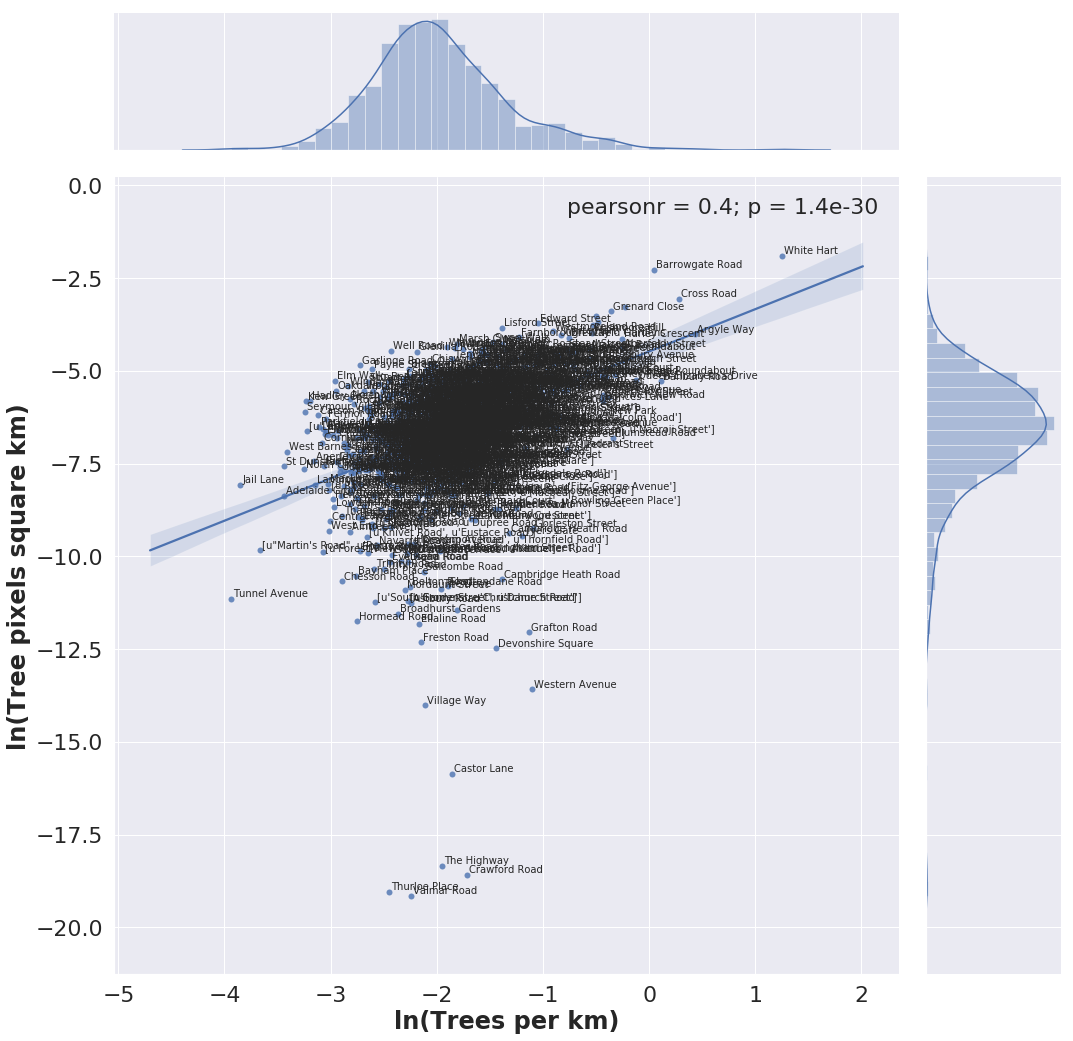

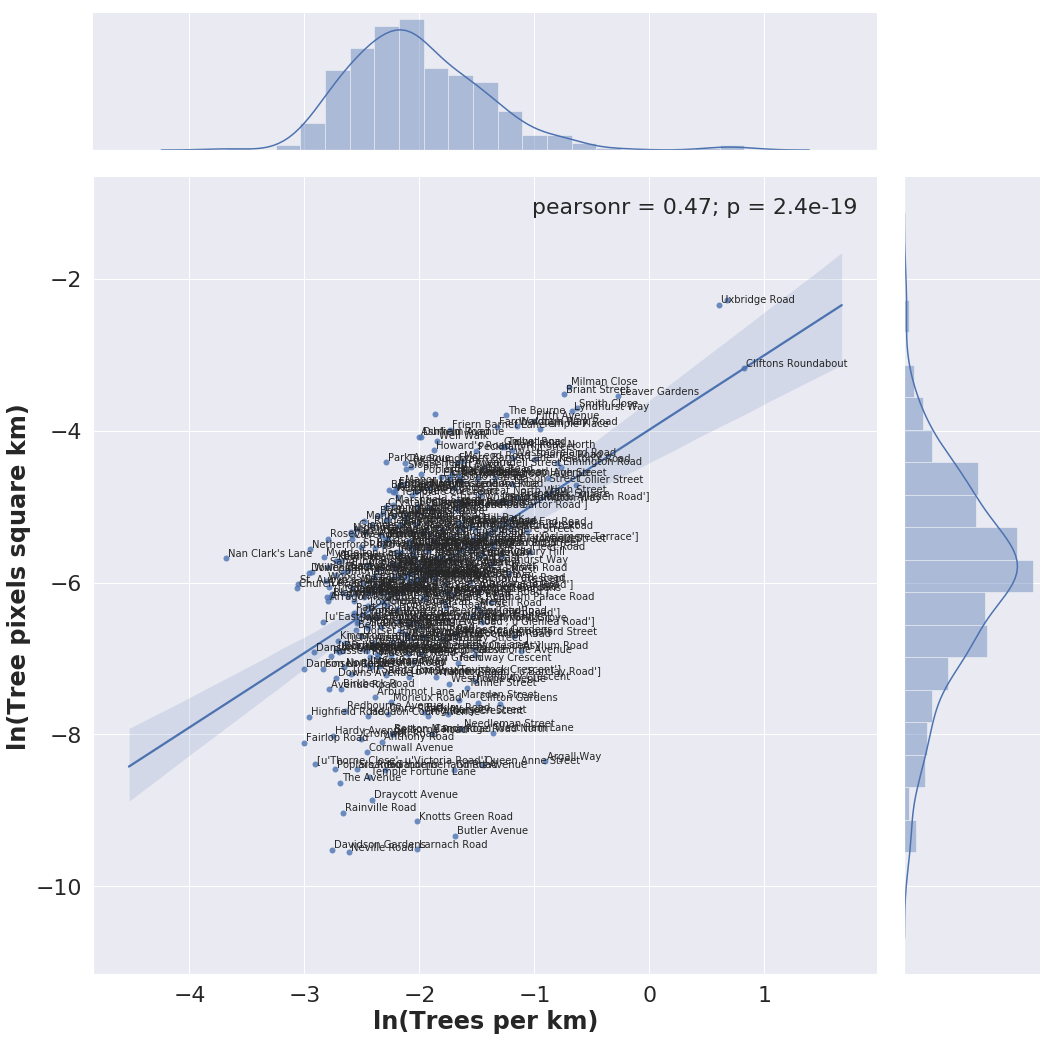

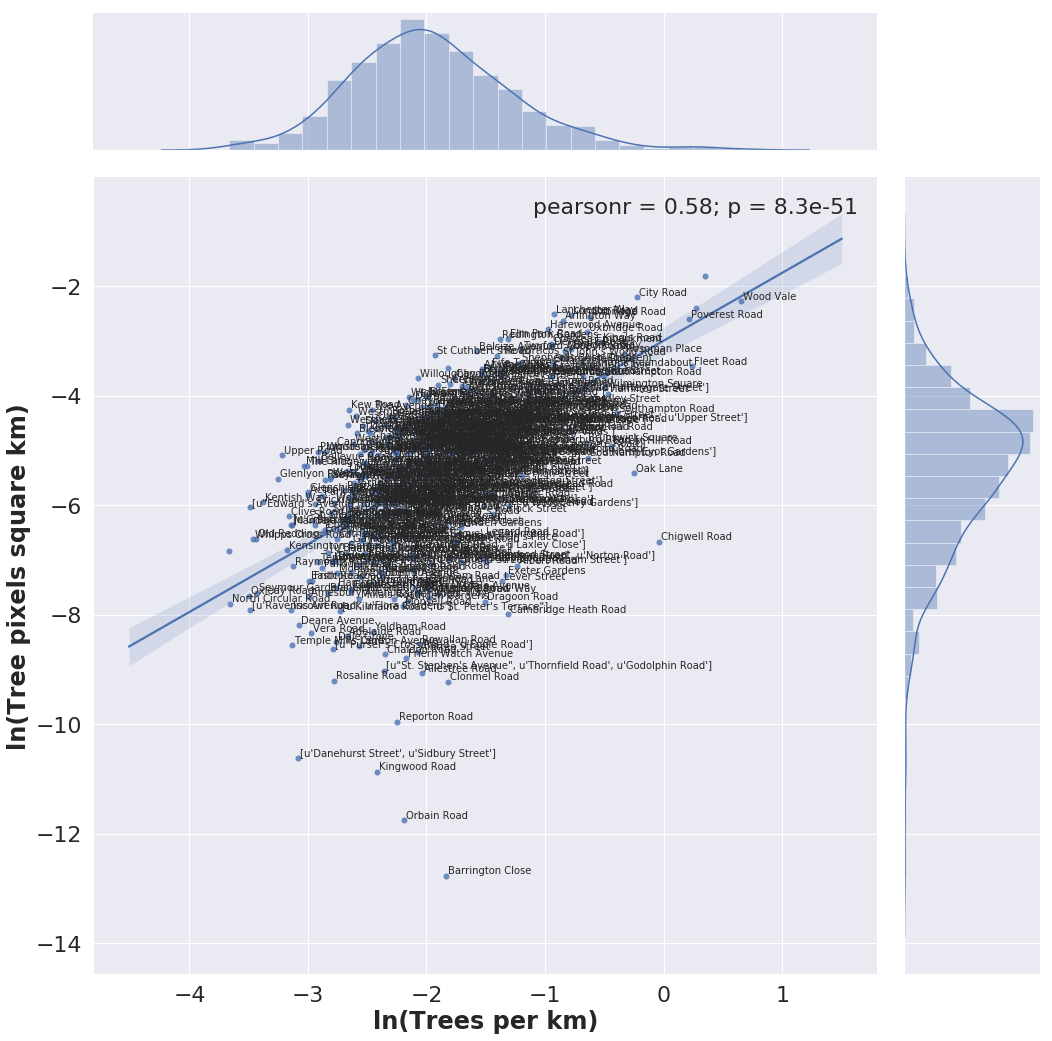

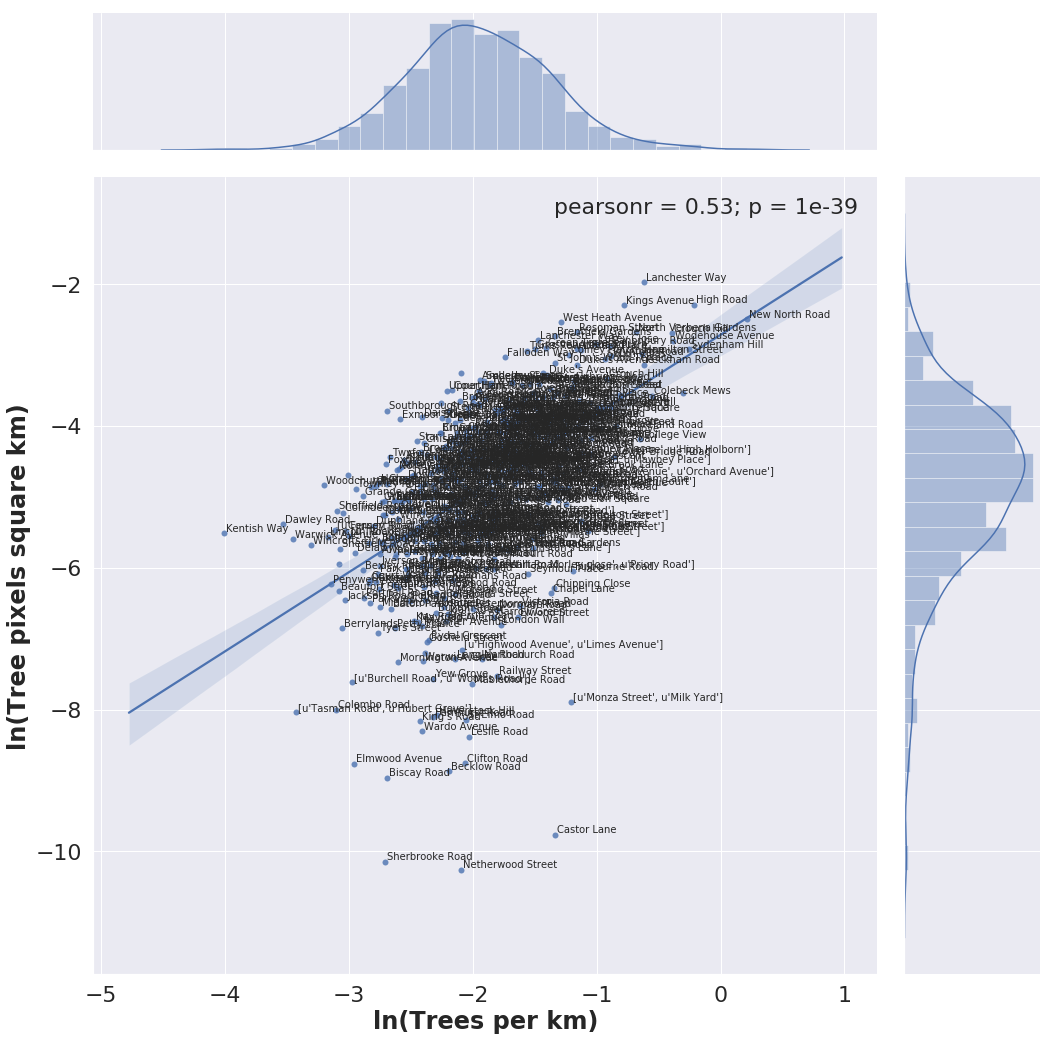

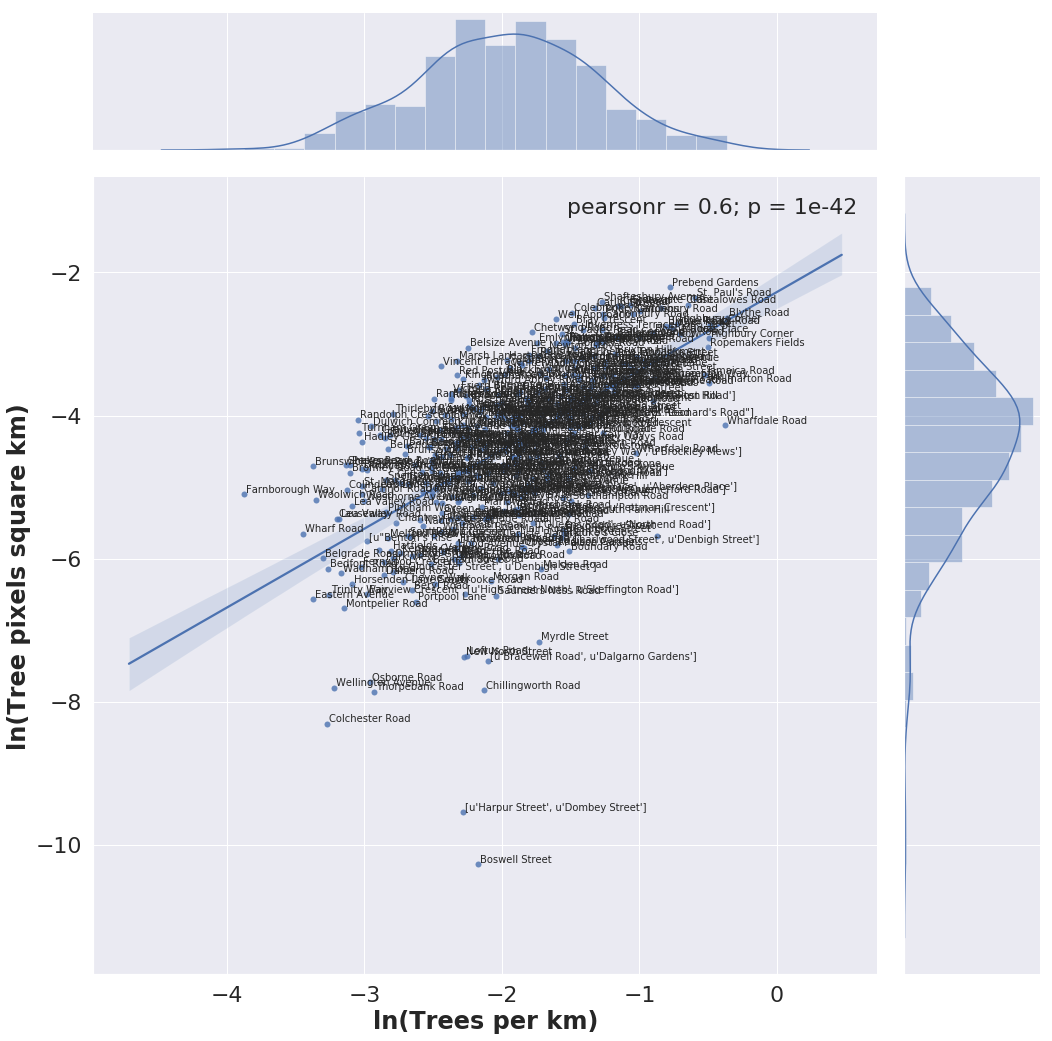

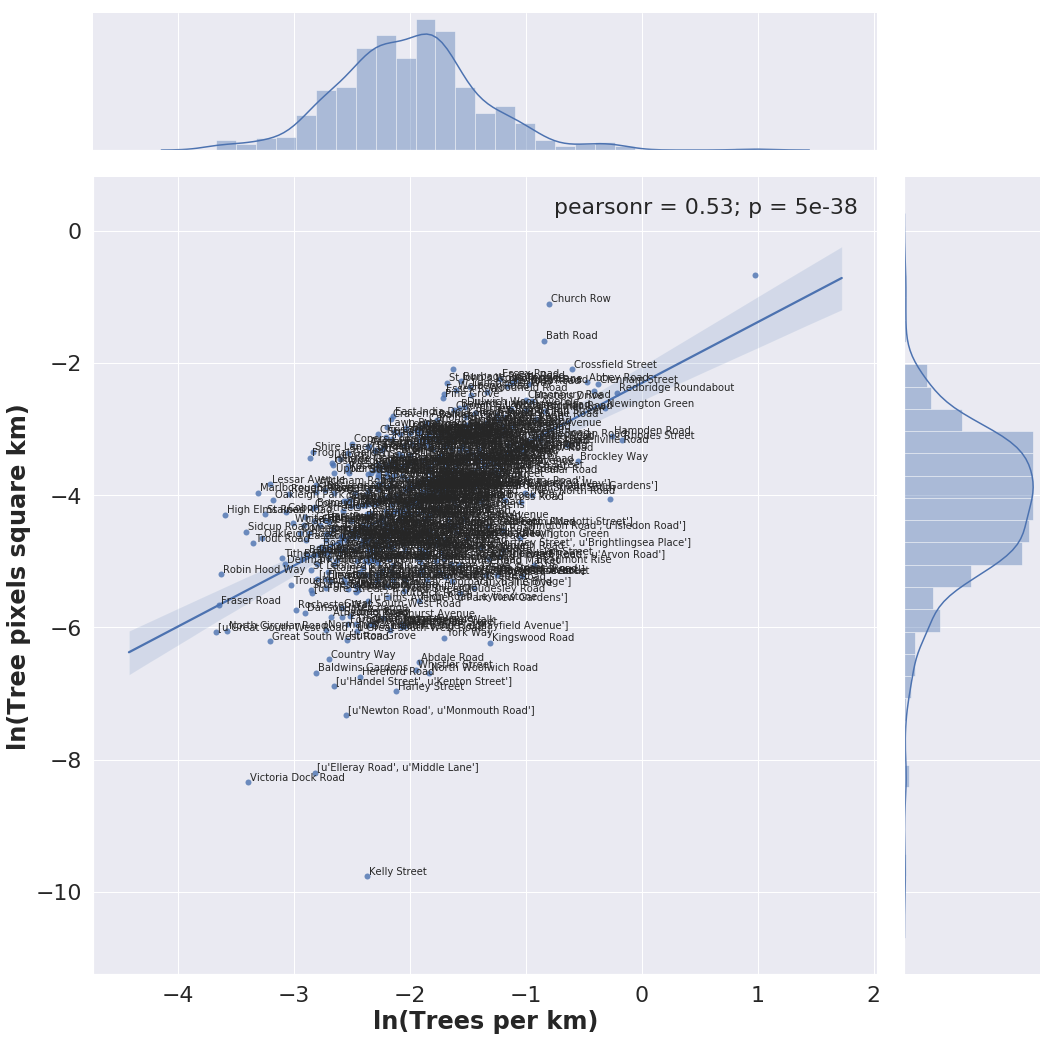

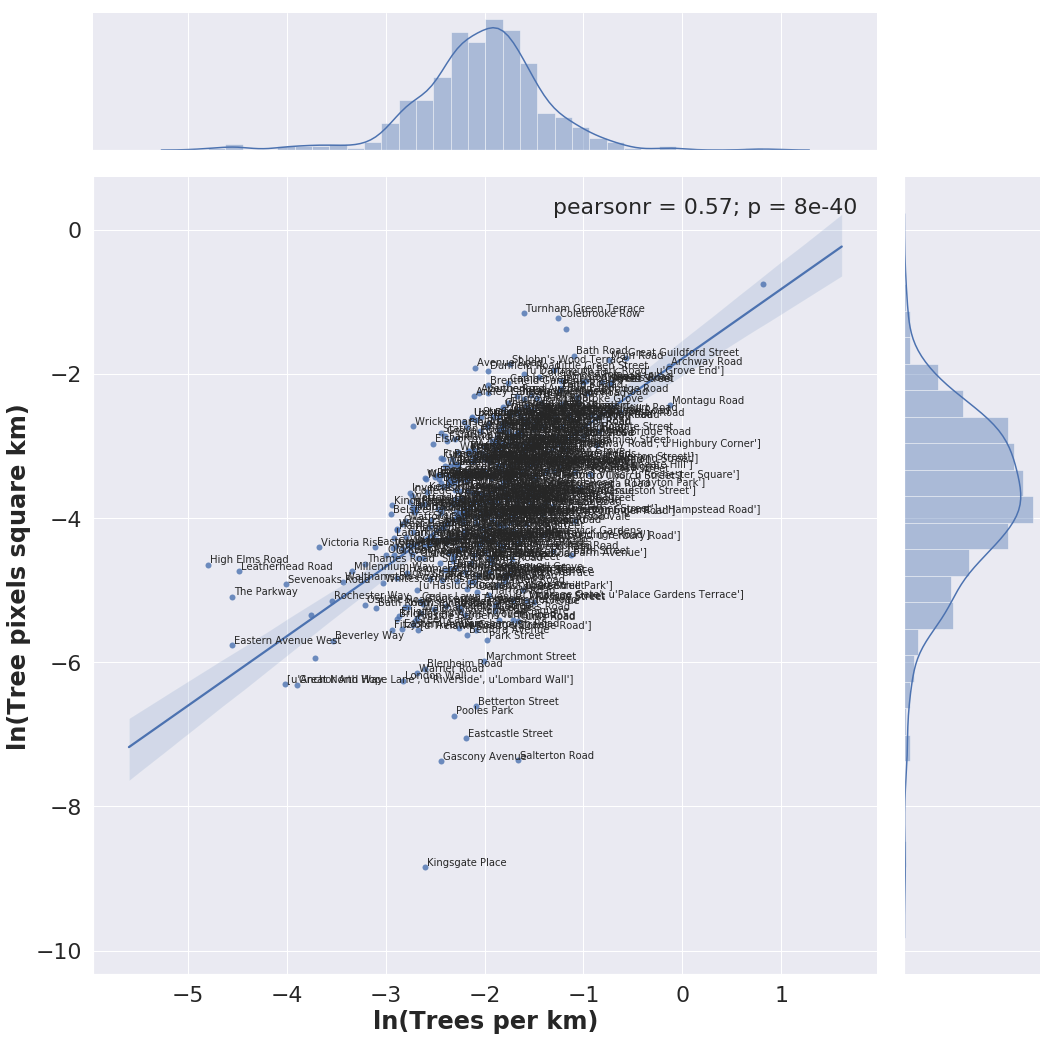

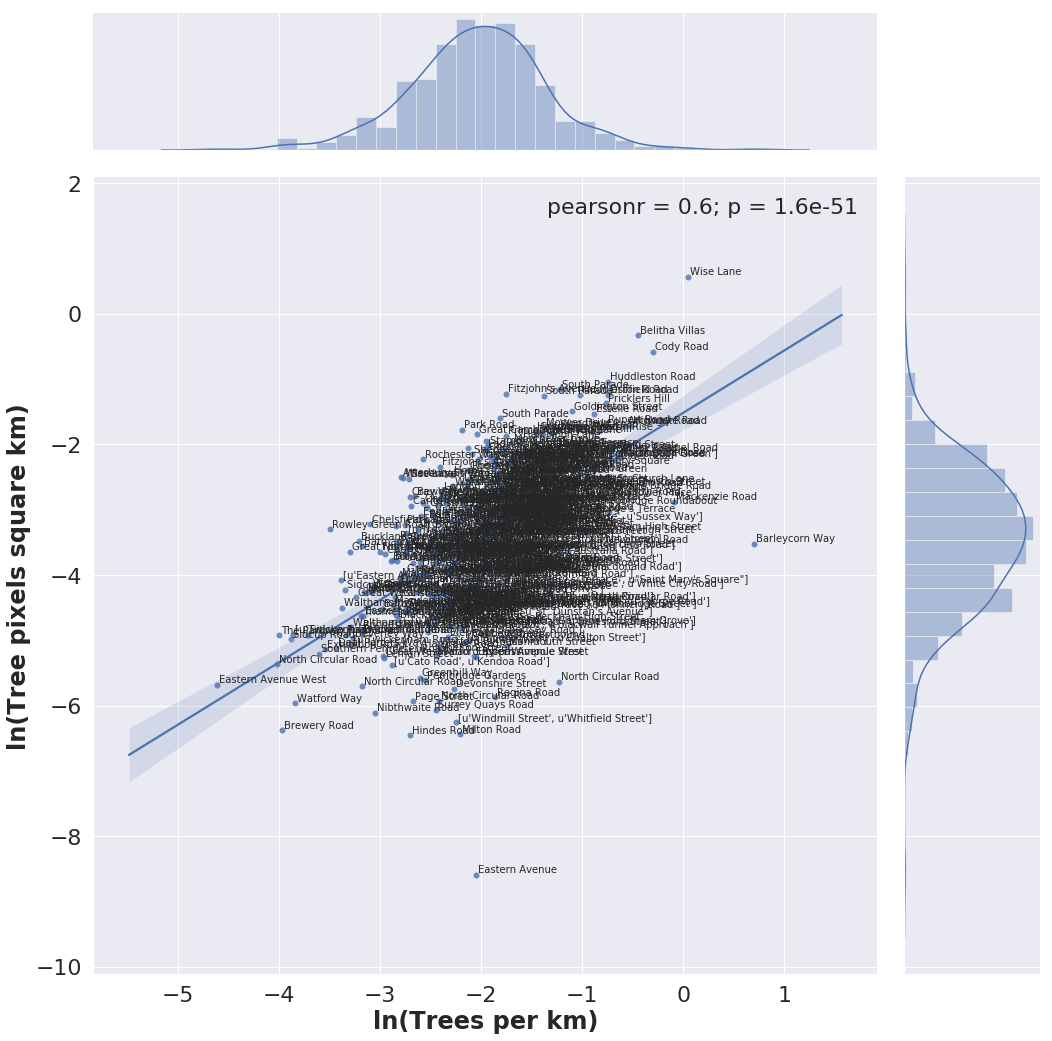

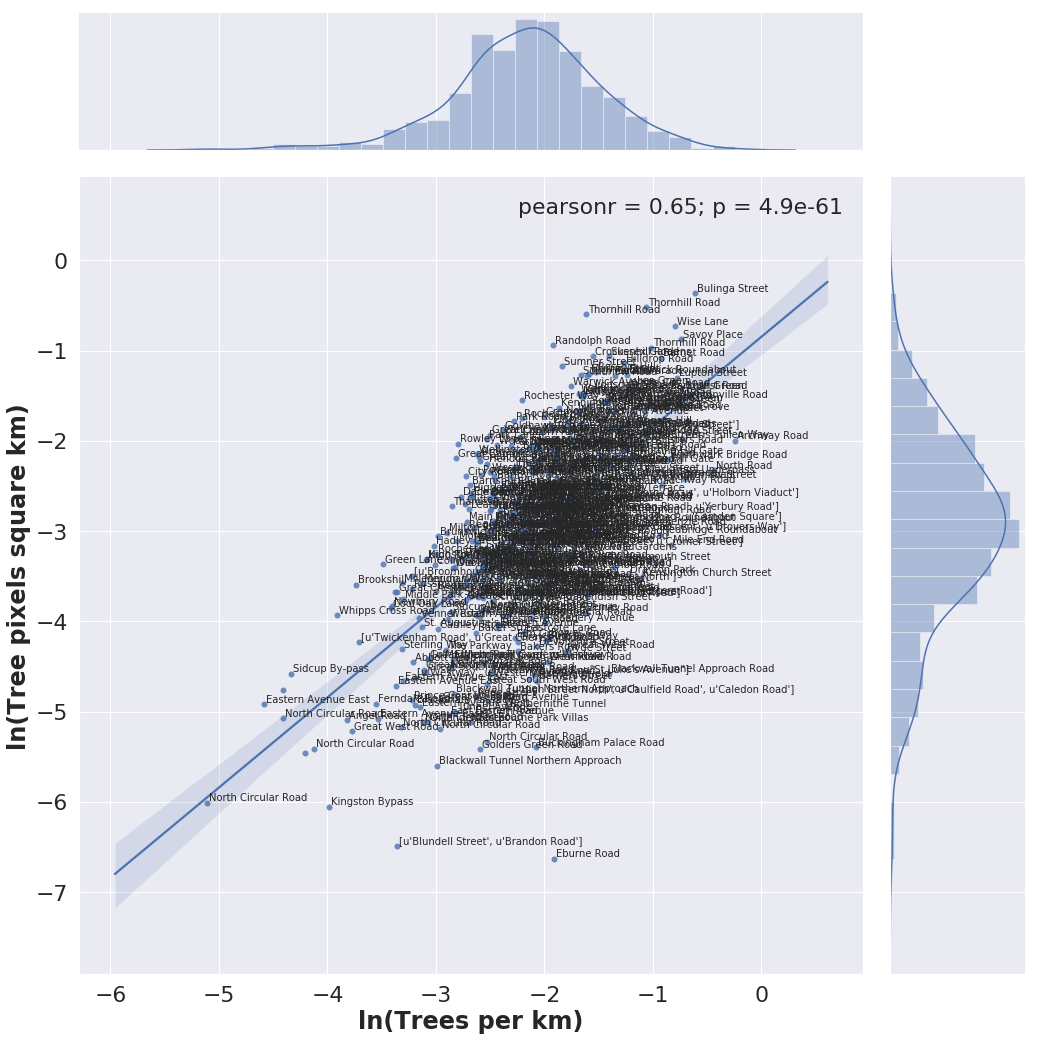

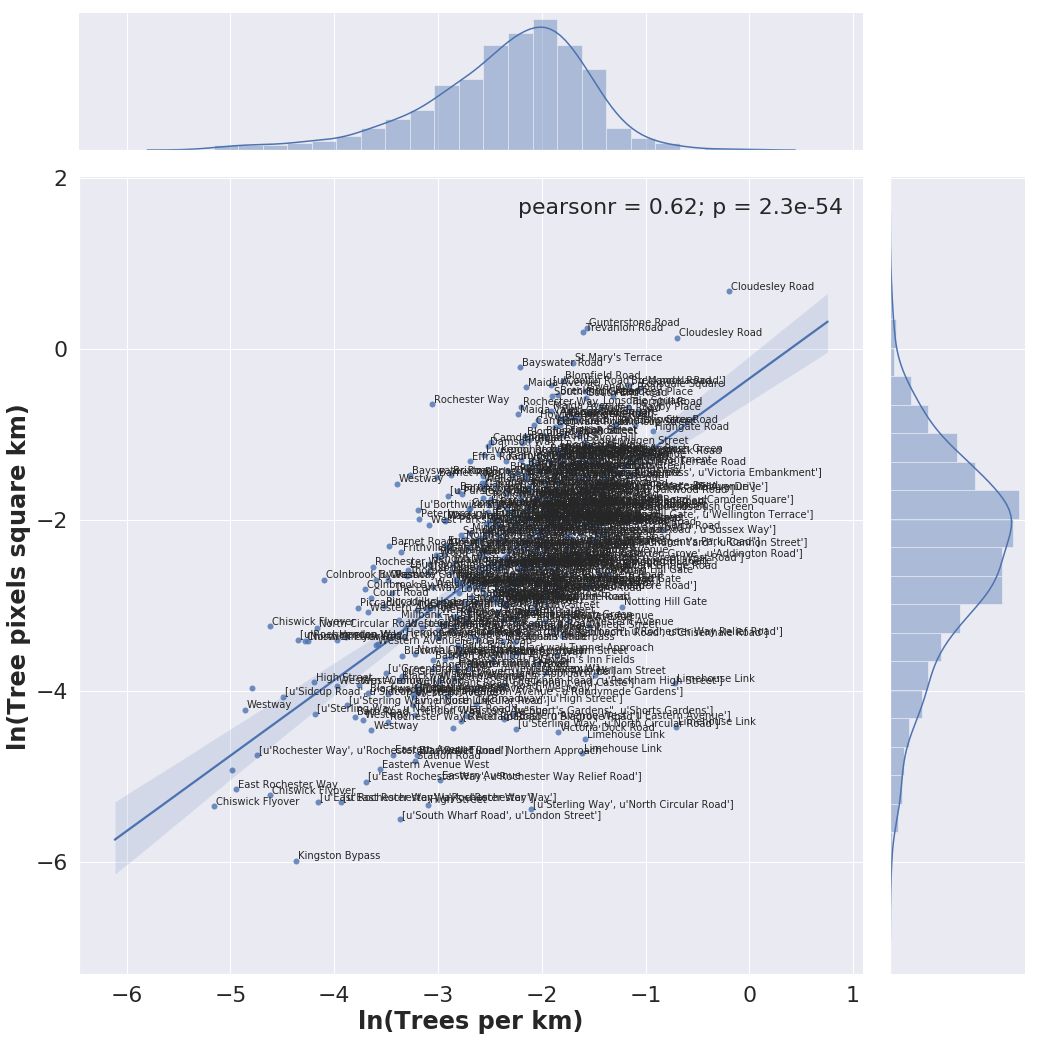

In [244]:
corrs_density = []
bins_density = []
for name, group in final_roads.groupby('decile'):
    bins_density.append(name)
    corr = pearsonr(group['Tree_density'],group['Tree_pixel_density'])

    print corr
    sns.set(font_scale=2) 
    ax = sns.jointplot(x="Tree_density", y="Tree_pixel_density", data=group,kind='regression',height=15);
    plt.xlabel('ln(Trees per km)')
    plt.ylabel('ln(Tree pixels square km)')
    ax.annotate(pearsonr)
    for row in group.iterrows():
        ann(row)
    corrs_density.append(corr)